In [1]:
import os, sys
from pathlib import Path
import loader 
import utils
from torch.utils.data import DataLoader
import torch 
import torchvision
# --------------------------- load Parameters from config ----------------------------------
config_path = os.path.join(Path.cwd(),'models\\VisionTransformer\\config.yaml')
params = utils.get_config_from_yaml(config_path)


# the dataset is set up he coppes images out of the original image i the set size 
# each epoch he takes a new slice of the original image 
# recomended sizes [64,64] / [128,128] / [256, 256]  
HE_img_dir = os.path.join(params['train_dir'],'HE')
IHC_img_dir = os.path.join(params['train_dir'],'IHC')
           
num_patches = (1024 * 1024) // params['img_size'][0]**2 


train_data = loader.stain_transfer_dataset( img_patch=  1,
                                            params= params,
                                            HE_img_dir = HE_img_dir,
                                            IHC_img_dir = IHC_img_dir,                                                     
                                           )
            
# get dataloader
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=False) 

            
real_HE, real_IHC,img_name = next(iter(train_data_loader))
contrast_IHC = torchvision.transforms.functional.adjust_contrast(real_IHC,3)


c:\Users\phili\OneDrive\Uni\WS_22\Masterarbeit\Masterarbeit_Code_Philipp_Rosin\torch_stain_transfer\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


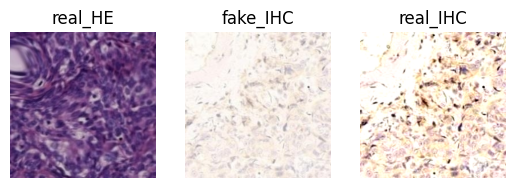

In [2]:

utils.plot_img_set(real_HE, real_IHC, contrast_IHC, 3,params,img_name,'train',1)

In [4]:
from torch import nn
#-----------------------------------------------------------------------------------------------
# PATCH EMBEDDING
#-----------------------------------------------------------------------------------------------
class patch_embedding(nn.Module):
    def __init__(self, in_channels, patch_size):
        super().__init__()
# ---------- inputs -------------------
# [N, in_channels, in_height, in_width]
# in_channels ------> int: number of channels in 
# patch_size -------> [w,h] : size of patch
#
# ---------- output -------------------
# P = patch_dim = (patch_size**2)* in_channels
# D = lossles embedding_dim = (in_width/patch_size[0])**2
# [N, P, D]
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.patch_dim = (patch_size[0]**2)* in_channels

        assert patch_size[0] == patch_size[1], "patch_embedding is only for square patches"

        self.patcher = nn.Conv2d(   in_channels=in_channels,
                                    out_channels = self.patch_dim,
                                    kernel_size = patch_size[0],
                                    stride = patch_size[0],
                                    padding = 0)
        
        self.flatten = nn.Flatten(  start_dim=2, 
                                    end_dim=3)
        
    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 

        return x_flattened

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 768, 256])


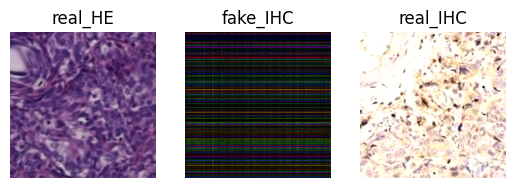

In [14]:

import math
patch_size = [16,16]
num_heads = 8
embedding_dim = int((256/16)**2)
x = real_HE

n, c, h, w = x.shape
patch_emb = patch_embedding(3,patch_size).to('cuda')
patches = patch_emb(x)
print(patches.shape)
unflatten = nn.Unflatten(2,(int(math.sqrt(embedding_dim)), int(math.sqrt(embedding_dim))))

unflatten = unflatten(patches)
reshaped = unflatten.reshape([n,c,h,w])

utils.plot_img_set(real_HE, reshaped, contrast_IHC, 3,params,img_name,'train',1)


In [4]:
from torch import nn
import torch 
x = torch.randn((1, 3072, 8, 8)).cuda()
x_1 = torch.randn((1, 3072, 64)).cuda()
model = nn.Conv2d(3072, 3, 1, 1, 0).cuda()
mlp = nn.Linear(64,64).cuda()
y_1 = mlp(x_1)
print(y_1.shape)
y = model(x)
print(y.shape)

torch.Size([1, 3072, 64])
torch.Size([1, 3, 8, 8])


In [ ]:
from U_net_pytorch import UNet
model = UNet(in_channels=params['in_channels'],out_channels=3, init_features=32).to(params['device'])
#model = U_net_Generator(in_channels=params['in_channels'], features=params['gen_features']).to(params['device'])

model_testing = eval.test_network(model,params,training_time)
model_testing.fit()

In [ ]:
def sample(self, model, n):
        #logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        
        return x


In [1]:
import tifffile as tiff 
a = tiff.imread("C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/peso_data/pds_2_HE.tif")

In [1]:
import utils
images={}
images["names"] = ["00092_train_2+", "00222_train_1+","00058_train_1+","00139_train_2+", "00392_train_2+"]
images["patch_num"] = [0,0,0,0,0]
plot_img = utils.publishing_plot(images, model_names= ["UNet", "pix2pix", ])
plot_img.show()

c:\Users\phili\OneDrive\Uni\WS_22\Masterarbeit\Masterarbeit_Code_Philipp_Rosin\torch_stain_transfer\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\phili\\OneDrive\\Uni\\WS_22\\Masterarbeit\\Masterarbeit_Code_Philipp_Rosin\\torch_stain_transfer\\code\\masterthesis_results\\U-Net\\4-step_f32\\config.yaml'